In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import  roc_curve, auc, RocCurveDisplay, classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

In [2]:
# Load pre-processed data
Poore_COAD = pd.read_csv("Poore_COAD", index_col=0)
Poore_COAD

,g__Cobetia,g__Ammonifex,g__Owenweeksia,g__Haloplasma,g__Desulfosarcina,g__Asaia,g__Parvibaculum,g__Neosynechococcus,g__Zymomonas,g__Kutzneria,...,portion_weight,aliquot_concentration,analyte_A260A280Ratio,analyte_amount,analyte_type_label,radiation_therapy_code_label,radiation_therapy_site_label,radiation_therapy_type_label,year_of_diagnosis,vital_status_label
sample_id1,,,,,,,,,,,,,,,,,,,,,
s13008,0.549996,3.627426,1.243335,0.200708,-0.019726,1.143794,3.529965,1.626574,-0.920077,2.144134,...,36.0,0.14,1.80,147.30,RNA,NaN,NaN,NaN,2009.0,Alive
s12994,1.036992,2.472233,1.813183,0.705863,-0.388531,1.448203,1.290475,2.069139,-0.342958,0.201402,...,110.0,0.15,1.72,132.38,RNA,NaN,NaN,NaN,2006.0,Dead
s13005,0.391081,4.148250,3.489199,0.059951,-1.034442,2.387254,3.451919,3.745155,0.596093,1.140453,...,137.0,0.17,1.80,583.30,RNA,NaN,NaN,NaN,2002.0,Dead
s12987,0.307795,1.743036,2.668948,-0.023334,-1.117728,2.303968,0.561278,1.339942,-1.072154,1.057168,...,158.0,0.14,1.80,438.30,RNA,NaN,NaN,NaN,2007.0,Alive
s12895,1.091898,2.527139,1.868089,2.345731,1.251338,1.503109,1.345381,2.124045,-0.288051,2.578236,...,114.0,0.13,1.80,533.30,RNA,NaN,NaN,NaN,2009.0,Alive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
s13862,0.955064,2.390305,1.731255,0.623935,1.114504,3.688203,1.208548,1.987211,-0.424885,1.704437,...,110.0,0.15,1.73,239.76,RNA,NaN,NaN,NaN,2009.0,Alive
s13849,2.017887,1.819532,0.994857,4.463031,-1.705226,0.955917,0.587535,1.494217,-1.100823,0.819574,...,129.0,0.15,1.80,877.30,RNA,NaN,NaN,NaN,2009.0,Alive
s13857,3.343320,2.743249,2.314112,1.020499,3.378589,1.981555,1.969840,2.411123,0.229642,-0.189119,...,36.0,0.14,1.70,19.80,RNA,951909FD-4B2B-4D3F-918A-34269D0A70FC,Primary Tumor Field,EXTERNAL BEAM,2008.0,Alive


In [3]:
class_counts = Poore_COAD['sample_type'].value_counts()
print(class_counts)

sample_type
Primary Tumor           825
Blood Derived Normal    109
Solid Tissue Normal      70
Metastatic                1
Recurrent Tumor           1
Name: count, dtype: int64


In [4]:
Poore_COAD = Poore_COAD[Poore_COAD['sample_type'] != 'Metastatic']
Poore_COAD = Poore_COAD[Poore_COAD['sample_type'] != 'Recurrent Tumor']
class_counts = Poore_COAD['sample_type'].value_counts()
print(class_counts)

sample_type
Primary Tumor           825
Blood Derived Normal    109
Solid Tissue Normal      70
Name: count, dtype: int64


In [5]:
# Prepare features and target variable
X = Poore_COAD.drop(['gdc_file_uuid', 'filename', 'age_at_diagnosis', 'aliquot_uuid',
       'case_uuid', 'days_to_death', 'disease_type', 'ethnicity',
       'experimental_strategy', 'gender', 'investigation', 'platform',
       'primary_site', 'race', 'reference_genome', 'sample_type',
       'sample_uuid', 'vital_status', 'tissue_source_site_label',
       'data_submitting_center_label', 'country_of_sample_procurement',
       'histological_diagnosis_label', 'pathologic_t_label',
       'pathologic_n_label', 'pathologic_stage_label', 'icd03_histology_label',
       'icd03_histology_site', 'icd10', 'portion_is_ffpe',
       'new_tumor_event_after_initial_trtmt',
       'primary_therapy_outcome_success_label', 'portion_weight',
       'aliquot_concentration', 'analyte_A260A280Ratio', 'analyte_amount',
       'analyte_type_label', 'radiation_therapy_code_label',
       'radiation_therapy_site_label', 'radiation_therapy_type_label',
       'year_of_diagnosis', 'vital_status_label'], axis=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

y = Poore_COAD['sample_type']
print("Unique values of y:", np.unique(y))
le = LabelEncoder()
y = le.fit_transform(y)
y
print("Unique values of y:", np.unique(y))

Unique values of y: ['Blood Derived Normal' 'Primary Tumor' 'Solid Tissue Normal']
Unique values of y: [0 1 2]


In [6]:
# Oversampling to ensure class balance
from imblearn.over_sampling import SMOTE
#oversampler = RandomOverSampler(sampling_strategy='minority', random_state=42)
#X_scaled, y = oversampler.fit_resample(X_scaled,y)

sm = SMOTE(sampling_strategy='not majority', k_neighbors= 5, random_state=42)
X_scaled, y = sm.fit_resample(X_scaled, y)

print(X_scaled.shape)
print(y.shape)

(2475, 1103)
(2475,)


Best Parameters: {'alpha': 1, 'colsample_bytree': 0.8, 'eta': 0.1, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.8}
Best Score: 0.9828282828282827
Test Set Accuracy: 0.9777777777777777


<Figure size 800x600 with 0 Axes>

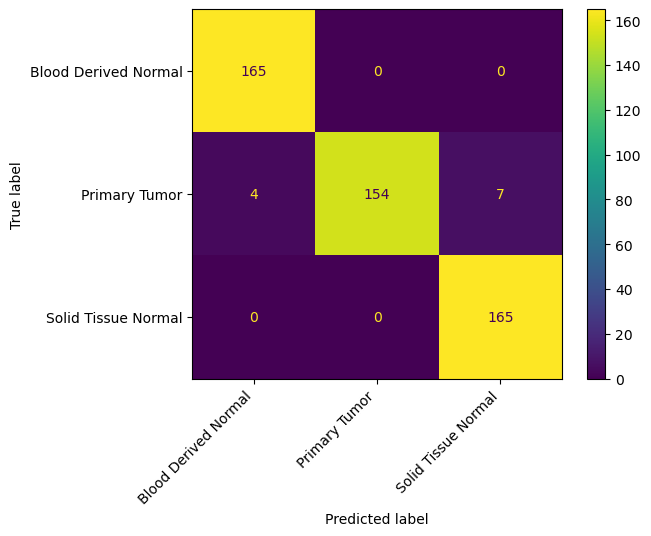

                      precision    recall  f1-score   support

Blood Derived Normal       0.98      1.00      0.99       165
       Primary Tumor       1.00      0.93      0.97       165
 Solid Tissue Normal       0.96      1.00      0.98       165

            accuracy                           0.98       495
           macro avg       0.98      0.98      0.98       495
        weighted avg       0.98      0.98      0.98       495



In [19]:
# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=True, random_state=42, stratify=y)

# Define parameters for XGBoost model
params = {
    'max_depth': [3, 4, 5],
    'eta': [0.01, 0.1],
    'alpha': [1],
    'colsample_bytree': [0.8],
    'subsample': [0.8, 0.9],
    'n_estimators':[100],
}
# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=3, eval_metric='mlogloss', seed=42)

# Use StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=params, scoring='accuracy', cv=cv)
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Evaluate the model on the test set
test_score = grid_search.best_estimator_.score(X_test, y_test)
print("Test Set Accuracy:", test_score)

y_pred = grid_search.best_estimator_.predict(X_test)

# Calculate and display confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Blood Derived Normal', 'Primary Tumor', 'Solid Tissue Normal'])
plt.figure(figsize=(8, 6))
cm_display.plot()
plt.xticks(rotation=45, ha='right')
plt.show()

# Calculate precision, recall, and F1-score
report = classification_report(y_test, y_pred, target_names=['Blood Derived Normal', 'Primary Tumor', 'Solid Tissue Normal'])
print(report)

In [20]:
from sklearn.metrics import roc_auc_score

# Train XGBoost model with best parameters for calculating feature importances
best_xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=3, eval_metric='mlogloss', **best_params)
y_score = best_xgb_model.fit(X_train, y_train).predict_proba(X_test)

micro_roc_auc_ovr = roc_auc_score(
    y_test,
    y_score,
    multi_class="ovr",
    average="micro",
)

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{micro_roc_auc_ovr:.2f}")

macro_roc_auc_ovr = roc_auc_score(
    y_test,
    y_score,
    multi_class="ovr",
    average="macro",
)

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{macro_roc_auc_ovr:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
1.00
Macro-averaged One-vs-Rest ROC AUC score:
1.00


C:\Users\Zhongyuan\AppData\Local\Temp\ipykernel_16244\3634286834.py:47: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', lw=2, color='black', label='Chance level (AUC = 0.5)')


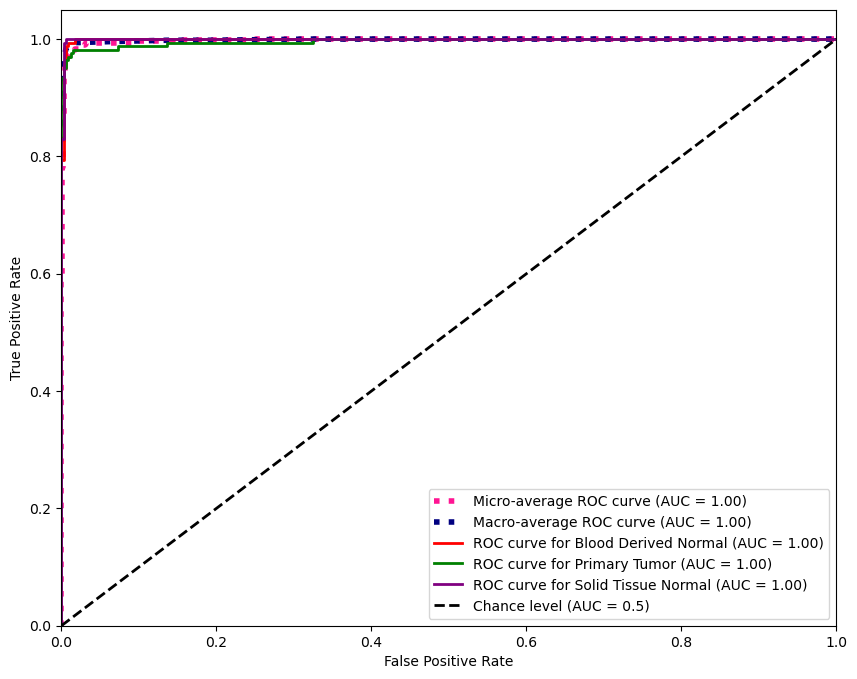

In [21]:
# Binarize the output labels
y_test_binarized = label_binarize(y_test, classes=np.arange(3))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(3)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(3):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= 3

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label='Micro-average ROC curve (AUC = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='Macro-average ROC curve (AUC = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = ['red', 'green', 'purple']
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve for {0} (AUC = {1:0.2f})'
             ''.format(le.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2, color='black', label='Chance level (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

C:\Users\Zhongyuan\AppData\Local\Temp\ipykernel_16244\2875457785.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances[top_20_indices], y=feature_names[top_20_indices], palette="viridis")


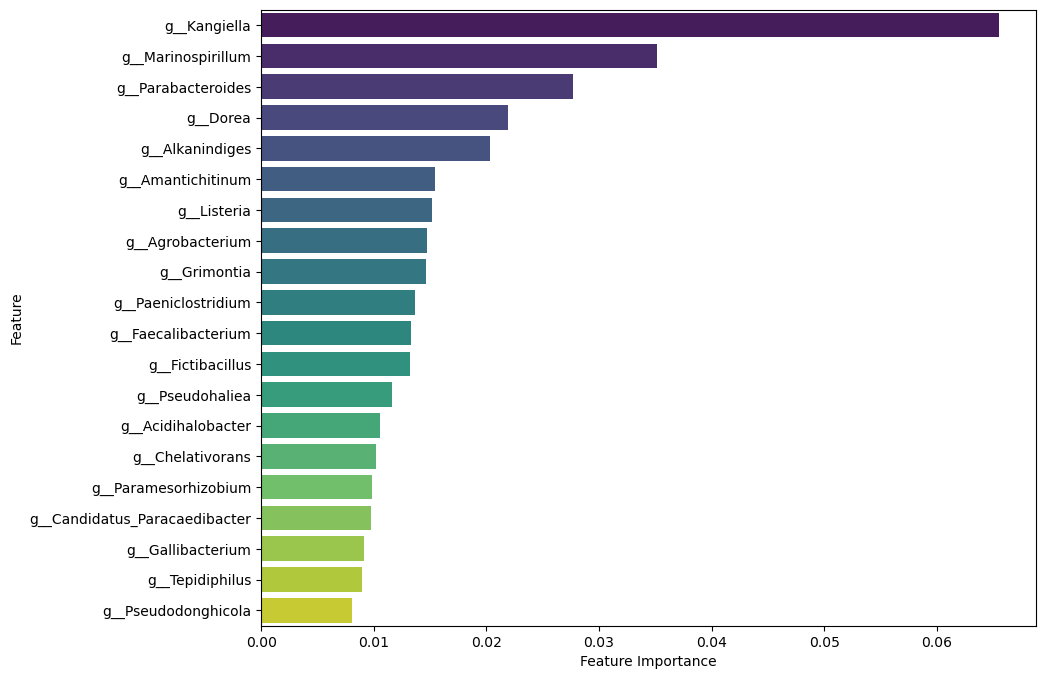

In [22]:
# Train XGBoost model with best parameters for calculating feature importances
best_xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=3, eval_metric='mlogloss', **best_params)
best_xgb_model.fit(X_train, y_train)

feature_importances = best_xgb_model.feature_importances_
top_20_indices = feature_importances.argsort()[::-1][:20]
feature_names = X.columns

plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importances[top_20_indices], y=feature_names[top_20_indices], palette="viridis")
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()

In [26]:
print(feature_names[top_20_indices])

Index(['g__Kangiella', 'g__Marinospirillum', 'g__Parabacteroides', 'g__Dorea',
       'g__Alkanindiges', 'g__Amantichitinum', 'g__Listeria',
       'g__Agrobacterium', 'g__Grimontia', 'g__Paeniclostridium',
       'g__Faecalibacterium', 'g__Fictibacillus', 'g__Pseudohaliea',
       'g__Acidihalobacter', 'g__Chelativorans', 'g__Paramesorhizobium',
       'g__Candidatus_Paracaedibacter', 'g__Gallibacterium', 'g__Tepidiphilus',
       'g__Pseudodonghicola'],
      dtype='object')


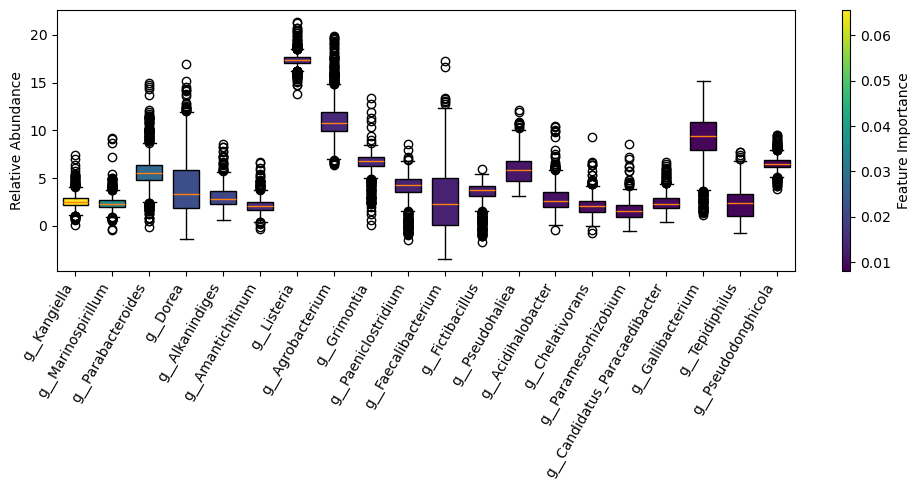

In [23]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

top_20_feature_names = feature_names[top_20_indices]

# Normalize feature importances
norm = Normalize(vmin=min(feature_importances[top_20_indices]), vmax=max(feature_importances[top_20_indices]))
cmap = plt.get_cmap('viridis')  # Choose a colormap
colors = [cmap(norm(importance)) for importance in feature_importances[top_20_indices]]

# Prepare data for boxplot
data = {}

for column_name in top_20_feature_names:
    data[column_name] = X[column_name]

# Plot boxplot
fig, ax = plt.subplots(figsize=(10, 5))

# Plot each box with the corresponding color based on feature importance
for i, (key, value) in enumerate(data.items()):
    box = ax.boxplot(value, positions=[i + 1], widths=0.7, patch_artist=True,
                     boxprops=dict(facecolor=colors[i], color='black'),
                     whiskerprops=dict(color='black'))

# Customize plot
ax.set_ylabel('Relative Abundance', fontsize=10)
ax.set_xticks(range(1, len(data) + 1))
ax.set_xticklabels(data.keys(), rotation=60, ha='right', fontsize=10)
plt.tight_layout()

# Add colorbar
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Only needed for colorbar, not for plotting
cbar = plt.colorbar(sm, ax=ax, aspect=30)
cbar.set_label('Feature Importance', fontsize=10)

plt.show()

In [7]:
#Evaluate the robustness of ML framework

from sklearn.metrics import precision_score, recall_score, f1_score

# Define parameters for XGBoost model
params = {
    'max_depth': [3, 4, 5],
    'eta': [0.01, 0.1],
    'alpha': [1], # Include L1 regularization
    'colsample_bytree': [0.8],
    'subsample': [0.8, 0.9],
    'n_estimators':[100],
}

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=3, eval_metric='mlogloss', seed=42)

# Use StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Robustness test
n_iterations = 20
robustness_train_scores = []
robustness_test_scores = []
robustness_auroc = []
precision_scores = []
recall_scores = []
f1_scores = []
important_features = []

for i in range(n_iterations):
    # Split the resampled data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=True, random_state=i, stratify=y)

    # Perform Grid Search with cross-validation
    grid_search = GridSearchCV(estimator=xgb_model, param_grid=params, scoring='accuracy', cv=cv)
    grid_search.fit(X_train, y_train)

    # Evaluate the model on the training data of the resampled set
    train_score = grid_search.best_score_
    robustness_train_scores.append(train_score)

    # Evaluate the model on the test data of the resampled set
    y_pred = grid_search.best_estimator_.predict(X_test)
    test_score = accuracy_score(y_test, y_pred)
    robustness_test_scores.append(test_score)
    
    # Calculate AUROC score
    y_test_proba = grid_search.best_estimator_.predict_proba(X_test)
    test_auroc = roc_auc_score(y_test, y_test_proba, multi_class='ovr', average='macro')
    robustness_auroc.append(test_auroc)

# Calculate precision, recall, and F1 score
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    # Extract the best model's parameters and feature importances
    best_params = grid_search.best_params_
    best_xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=3, eval_metric='mlogloss', **best_params)
    best_xgb_model.fit(X_train, y_train)

    feature_importances = best_xgb_model.feature_importances_
    top_20_indices = feature_importances.argsort()[::-1][:20]
    feature_names = X.columns
    top_20_features = feature_names[top_20_indices]
    important_features.extend(top_20_features)

# Calculate statistics for training data
robustness_train_mean = np.mean(robustness_train_scores)
robustness_train_std = np.std(robustness_train_scores)

# Calculate statistics for test data
robustness_test_mean = np.mean(robustness_test_scores)
robustness_test_std = np.std(robustness_test_scores)

# Calculate statistics for AUROC
robustness_auroc_mean = np.mean(robustness_auroc)
robustness_auroc_std = np.std(robustness_auroc)

# Calculate mean and standard deviation for precision, recall, and F1 score
mean_precision = np.mean(precision_scores)
std_precision = np.std(precision_scores)
mean_recall = np.mean(recall_scores)
std_recall = np.std(recall_scores)
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)

print("Train Mean Accuracy:", robustness_train_mean)
print("Train Std Accuracy:", robustness_train_std)
print("Test Mean Accuracy:", robustness_test_mean)
print("Test Std Accuracy:", robustness_test_std)
print("Mean AUROC:", robustness_auroc_mean)
print("Std AUROC:", robustness_auroc_std)
print("Mean Precision:", mean_precision)
print("Std Precision:", std_precision)
print("Mean Recall:", mean_recall)
print("Std Recall:", std_recall)
print("Mean F1 Score:", mean_f1)
print("Std F1 Score:", std_f1)


Train Mean Accuracy: 0.9808838383838385
Train Std Accuracy: 0.002162153006120352
Test Mean Accuracy: 0.9854545454545456
Test Std Accuracy: 0.006957242568776793
Mean AUROC: 0.9995779002142638
Std AUROC: 0.0004647528181638353
Mean Precision: 0.985757088164166
Std Precision: 0.0067743314029016085
Mean Recall: 0.9854545454545456
Std Recall: 0.0069572425687768
Mean F1 Score: 0.9853867608159396
Std F1 Score: 0.007009512058902788


In [8]:
print(f"Train_accuracy_scores: {robustness_train_scores}" )
print(f"Test_accuracy_scores: {robustness_test_scores}" )
print(f"AUROC_scores: {robustness_auroc}" )
print(f"precision_scores: {precision_scores}" )
print(f"recall_scores: {recall_scores}" )
print(f"f1_scores: {f1_scores}" )

Train_accuracy_scores: [0.9823232323232324, 0.9818181818181818, 0.9767676767676768, 0.9858585858585858, 0.9808080808080808, 0.9808080808080808, 0.9813131313131314, 0.9777777777777779, 0.9792929292929292, 0.983838383838384, 0.9803030303030305, 0.9772727272727273, 0.9797979797979798, 0.9823232323232324, 0.9828282828282828, 0.9818181818181818, 0.9808080808080808, 0.9823232323232325, 0.9787878787878789, 0.9808080808080808]
Test_accuracy_scores: [0.9858585858585859, 0.9919191919191919, 0.9818181818181818, 0.9818181818181818, 0.9919191919191919, 0.9797979797979798, 0.9656565656565657, 0.9919191919191919, 0.9959595959595959, 0.9858585858585859, 0.9818181818181818, 0.98989898989899, 0.9939393939393939, 0.9797979797979798, 0.9757575757575757, 0.9878787878787879, 0.9838383838383838, 0.98989898989899, 0.98989898989899, 0.9838383838383838]
AUROC_scores: [0.9996388123660851, 0.9995592286501377, 0.9997612488521579, 0.9998836853382308, 0.9999510254055709, 0.9993265993265993, 0.9989531680440772, 0.999

In [9]:
# Print or process the list of important features
print("Total number of selected features:", len(important_features))
important_features = pd.DataFrame(important_features)
important_features.to_csv('FI_XGB_TCGA_ST.csv', index=False)

Total number of selected features: 400
